In [1]:
import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import matplotlib
import time
from numba import njit

from tqdm            import tqdm
from scipy           import signal

from propagation import received_power, propagation_delay, map_rx_config, map_tx_config

from parametermeasurement import generate_clocks, \
                                 measure_range_bechadergue_dflipflop, \
                                 measure_range_bechadergue_counter

### Simulation preliminaries

In [2]:
weather     = 'clear' 
temperature = 298 # Kelvin
daynight    = 'night'

daynight_noise_factors = dict()
daynight_noise_factors['day_directsun']   = 1.000 # 5100 uA
daynight_noise_factors['day_indirectsun'] = 0.145 # 740 uA
daynight_noise_factors['night']           = 0.010 # very small

# minmax bounds to be safe if you set the noise factor yourself
bg_current = (np.minimum(1, np.maximum(0, daynight_noise_factors[daynight]))*5100)*1e-6;

weather_attenuation_factors = dict()
weather_attenuation_factors['clear'] = 0.0
weather_attenuation_factors['rain']  = -0.05
weather_attenuation_factors['fog']   = -0.2

atten = weather_attenuation_factors[weather];

In [3]:
a = np.load('optics/qrx_planoconvex.npz');
f_QRX, pd_snst, pd_gain, pd_dim, rx_P_rx_factor, rx_I_bg_factor, rx_thermal_factor1, rx_thermal_factor2 = map_rx_config(a);

In [4]:
a = np.load('optics/tx_lambertian_20deg_2W.npz')
tx_ha, tx_pwr, tx_norm, tx_lambertian_order = map_tx_config(a);

In [5]:
c         = 299702547 #299702547  # [m/s] speed of light
f_dig_clk = 1e8;      # [Hz], bechadergue digital counter clock freq
f_adc_clk = 1e7;      # [Hz], roberts ADC measurement clock freq
f_e       = 1.0e6;    # [Hz], emitted wave freq, left TX
r         = 5000;     # unitless, heterodyning factor
N         = 4;        # unitless, averaging factor for left TX

f_sim = 1e10 # [Hz]

this factor is precomputed since it's the same for all links

In [6]:
# original bandwidth = 10 MHz, we assume a 100 kHz BPF here like bechadergue, effectively reducing BW by 100x 
#
# see noise variance equations for further info on this
bandwidth_scaling_due_to_filter = 0.01;
thermal_and_bg_curr = rx_I_bg_factor *  bandwidth_scaling_due_to_filter * bg_current + \
                      temperature    *( bandwidth_scaling_due_to_filter * rx_thermal_factor1 + \
                                      ( bandwidth_scaling_due_to_filter**3) * rx_thermal_factor2)

add_noise = 1

### Simulate propagation

generate simulation and adc clock signals

the time resolution of the simulation clock determines the minimum spatial resolution representable on the received signal, i.e., 1 tick on the simulation clock corresponds to x cm light travel distance. 

Note that this is not the resolution of the auto-digital method ($d_{min}$), but for meaningful simulations, we need to make sure that the minimum spatial resolution of the simulation is at least equal to $d_{min}$. Also, note that the output of the auto-digital method can go to higher precision using the averaging factor $N$.

In [7]:
t_sim, t_sim_stop, sim_res, s_sim, s_adc_re, s_dig_re = generate_clocks(c, f_e, N, r, f_sim, f_adc_clk, f_dig_clk)

d_min = c/(2*r*f_e);

print("sim stop time:",t_sim_stop, "s")
print("sim length   :",int(t_sim_stop/t_sim),"samples")
print("sim time res :", t_sim*(10**12), "ps")
print("sim tvec size:", s_sim.nbytes/(1024**3), "GB")
print("sim space res:", 100*sim_res, "cm")
print("")
print("d_min    :", d_min*100, "cm")
print("d_min w/N:", d_min*100/N, "cm")
print("rate     :", 2*f_e/(N*(r+1)), "Hz")

sim stop time: 0.0105021 s
sim length   : 105021000 samples
sim time res : 100.0 ps
sim tvec size: 0.7824674248695374 GB
sim space res: 2.99702547 cm

d_min    : 2.99702547 cm
d_min w/N: 0.7492563675 cm
rate     : 99.98000399920016 Hz


the testing points, i.e., range values, need to be decimated according to simulation spatial resolution for meaningful results, so quantize them accordingly. When $d_{min}$=spatial resolution, deterministic quantization error is also prevented. Since there's also no heterodyning error here (see gate pulse graph below, we always align the simulation time windows for each testing point separately), this simulation only considers the statistical effects arising from channel noise. 

In [8]:
range_start = 01.00
range_stop  = 20.00

range_decimation_factor = 50; # no need to go through all of them, standard deviation will evolve smoothly anyhow
quantization_factor = sim_res

rg = np.linspace(range_start, range_stop, 
                 int((range_stop-range_start)/(range_decimation_factor*quantization_factor))+1)
rg = (quantization_factor)*np.round(rg/quantization_factor)

x = np.zeros(rg.shape[0]);

hdg = np.zeros(rg.shape[0]); # parallel vehicles

In [9]:
pwr   = received_power(x, rg, 0, pd_dim/1000, hdg, tx_pwr, tx_norm, tx_lambertian_order, atten)
delay = propagation_delay(x, rg, c)

### Simulate ranging

pre-compute the quantities that do not change over the test track to save on simulation time, these are:

- $s_e$: first transmitted signal (logic, sim time)
- $s_{e,sin}$: same as $s_e$, but used for the DFT-based method so no zero-crossing detection necessary + it's clocked, so (sin, clocked)
- $s_h$: heterodyning signal (logic, sim time)
- $s_{gate}$: generated in sim time as a sine wave, then zero-crossing converts it to a logic signal, and then it's clocked, so (logic, clocked)


In [10]:
s_h = np.sin(2*np.pi* f_e*(r/(r+1))*s_sim - np.pi/32)>0;
s_e = np.sin(2*np.pi* f_e *s_sim - np.pi/32)>0;
s_eh = measure_range_bechadergue_dflipflop(s_e, s_h)[s_dig_re]
s_gate = np.sin(2*np.pi* f_e*(1/(N*(r+1))) *s_sim - np.pi/32)>0;
s_gate = s_gate[s_dig_re]

s_e_sin = np.sin(2*np.pi* f_e *s_sim[s_adc_re] - np.pi/32);
s_e_sin = sp.fft.fft(s_e_sin);
s_e_sin[0:int(s_e_sin.shape[0]/2)] = 0;
s_e_sin = sp.fft.ifft(s_e_sin);

for each location on the test track, we measure estimations produced for one gate pulse:

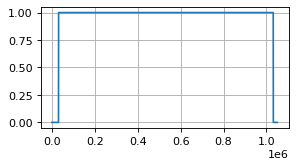

In [11]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=80)
ax.plot(s_gate)
ax.grid()
plt.show()

njit'ed utility functions to speed up simulation

In [12]:
@njit(parallel=True, fastmath=True)
def gen_rx(rx_peakAmps, f, s_simulation, delay, rx_noise_stdev, noise, pd_gain):
    return (rx_peakAmps*(np.sin(2*np.pi*f*(s_simulation - 2*delay) - np.pi/32)) / 2 + rx_noise_stdev * noise)*pd_gain;

@njit(parallel=True, fastmath=True)
def s_r_zc(s_r_sin):
    return s_r_sin > 0;

@njit(parallel=True, fastmath=True)
def gen_noise(s_sim_shape):
    return np.random.randn(s_sim_shape);

In [13]:
iterations = 100;
d_bec = np.zeros((iterations, x.shape[0]))
d_rob = np.zeros((iterations, x.shape[0]))

for j in tqdm(range(0, iterations)):
    ns = gen_noise(s_sim.shape[0]);
    for i in range(0, rg.shape[0]):
        delay          = rg[i]/c
        rx_peakAmps    = pwr[i]*pd_snst
        rx_noise_stdev = np.sqrt(bandwidth_scaling_due_to_filter*rx_P_rx_factor*pwr[i] + thermal_and_bg_curr);         
        
        s_r_sin = gen_rx(rx_peakAmps, f_e, s_sim, delay, rx_noise_stdev, ns, pd_gain)
        
        ### roberts
        s_r_f = sp.fft.fft(s_r_sin[s_adc_re]);
        s_r_f[0:int(s_r_f.shape[0]/2)] = 0;
        s_r_f = sp.fft.ifft(s_r_f);
        
        phase_shift_diff_est = np.mean(np.angle(s_e_sin * np.conjugate(s_r_f)));
        del s_r_f
        d_rob[j,i] = c*(phase_shift_diff_est/(2*np.pi*2*f_e))       
        
        ### bechadergue
        s_r = s_r_zc(s_r_sin)
        del s_r_sin
        s_rh = measure_range_bechadergue_dflipflop(s_r, s_h)[s_dig_re]
        del s_r
        s_phi    = np.logical_xor(s_eh, s_rh);
        s_phi_pp = s_phi*s_gate # clock applied implicitly with adc_clock_re

        count = measure_range_bechadergue_counter(s_phi_pp, s_gate)
        f_i = f_e/(r+1);
        phase_shift_est = 2*np.pi*(np.asarray(count)*f_i/(N*f_dig_clk))
        d_bec[j,i] = c*(phase_shift_est/(2*np.pi*2*f_e))
        

100%|██████████| 100/100 [19:20<00:00, 11.60s/it]


In [14]:
np.savez('testtrack_ranging_roberts_clearnight.npz', 
        rg=rg, 
        c=c, 
        d_rob=d_rob, 
        pwr=pwr,
        f_e = f_e,
        f_adc_clk=f_adc_clk,
        r=r,
        N=N,
        daynight=daynight,
        weather=weather,
        temperature=temperature)

In [15]:
np.savez('testtrack_ranging_becha_clearnight.npz', 
        rg=rg, 
        c=c, 
        d_bec=d_bec, 
        pwr=pwr,
        f_e = f_e,
        f_dig_clk=f_dig_clk,
        r=r,
        N=N,
        daynight=daynight,
        weather=weather,
        temperature=temperature)

# plot

In [7]:
bec_clearnight        = np.load('results/es1_testtrack_ranging/testtrack_ranging_becha_clearnight.npz')
bec_rainsun           = np.load('results/es1_testtrack_ranging/testtrack_ranging_becha_rainsun.npz')
rob_adc1e7_clearnight = np.load('results/es1_testtrack_ranging/testtrack_ranging_roberts_clearnight.npz')
rob_adc1e7_rainsun    = np.load('results/es1_testtrack_ranging/testtrack_ranging_roberts_rainsun.npz')

In [8]:
rg = bec_clearnight['rg']

d_bec_clearnight = bec_clearnight['d_bec']
d_rob_adc1e7_clearnight = rob_adc1e7_clearnight['d_rob']

d_bec_rainsun = bec_rainsun['d_bec']
d_rob_adc1e7_rainsun = rob_adc1e7_rainsun['d_rob']

d_bec_clearnight_error = d_bec_clearnight-rg
d_rob_adc1e7_clearnight_error = d_rob_adc1e7_clearnight + rg

d_bec_rainsun_error    = d_bec_rainsun-rg
d_rob_adc1e7_rainsun_error = d_rob_adc1e7_rainsun + rg

In [9]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


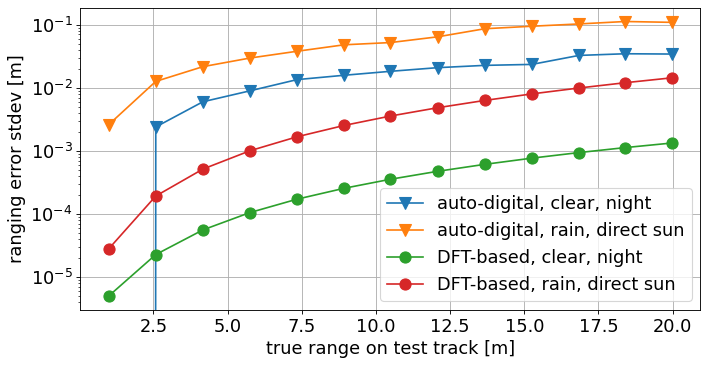

In [10]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=80)
ax.semilogy(rg, np.std(d_bec_clearnight_error         ,axis=0),'-v', markersize=10)
ax.semilogy(rg, np.std(d_bec_rainsun_error            ,axis=0),'-v', markersize=10)
ax.semilogy(rg, np.std(d_rob_adc1e7_clearnight_error  ,axis=0),'-o', markersize=10)
ax.semilogy(rg, np.std(d_rob_adc1e7_rainsun_error     ,axis=0),'-o', markersize=10)
ax.grid()
ax.legend(['auto-digital, clear, night', 
           'auto-digital, rain, direct sun', 
           'DFT-based, clear, night', 
           'DFT-based, rain, direct sun'])
plt.ylabel('ranging error stdev [m]')
plt.xlabel('true range on test track [m]')
plt.show()